# Project - AllLife Credit Card Customer Segmentation

### Installing packages

In [1]:
!pip3 install xlrd==1.2.0
!pip3 install openpyxl

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
data = pd.read_excel('Credit Card Customer Data.xlsx', engine='openpyxl',index_col='Sl_No')
data.head()

,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Sl_No,,,,,,
1,87073,100000,2,1,1,0
2,38414,50000,3,0,10,9
3,17341,50000,7,1,3,4
4,40496,30000,5,1,1,4
5,47437,100000,6,0,12,3


## EDA

In [4]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 660 entries, 1 to 660
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Customer Key         660 non-null    int64
 1   Avg_Credit_Limit     660 non-null    int64
 2   Total_Credit_Cards   660 non-null    int64
 3   Total_visits_bank    660 non-null    int64
 4   Total_visits_online  660 non-null    int64
 5   Total_calls_made     660 non-null    int64
dtypes: int64(6)
memory usage: 36.1 KB
None


In [5]:
print(data.describe().transpose())

                     count          mean           std      min       25%  \
Customer Key         660.0  55141.443939  25627.772200  11265.0  33825.25   
Avg_Credit_Limit     660.0  34574.242424  37625.487804   3000.0  10000.00   
Total_Credit_Cards   660.0      4.706061      2.167835      1.0      3.00   
Total_visits_bank    660.0      2.403030      1.631813      0.0      1.00   
Total_visits_online  660.0      2.606061      2.935724      0.0      1.00   
Total_calls_made     660.0      3.583333      2.865317      0.0      1.00   

                         50%      75%       max  
Customer Key         53874.5  77202.5   99843.0  
Avg_Credit_Limit     18000.0  48000.0  200000.0  
Total_Credit_Cards       5.0      6.0      10.0  
Total_visits_bank        2.0      4.0       5.0  
Total_visits_online      2.0      4.0      15.0  
Total_calls_made         3.0      5.0      10.0  


In [6]:
duplicate = data[data.duplicated()]
print("Number of duplicate records found %d" % duplicate.shape[0])

Number of duplicate records found 0


In [7]:
print(data.nunique())

Customer Key           655
Avg_Credit_Limit       110
Total_Credit_Cards      10
Total_visits_bank        6
Total_visits_online     16
Total_calls_made        11
dtype: int64


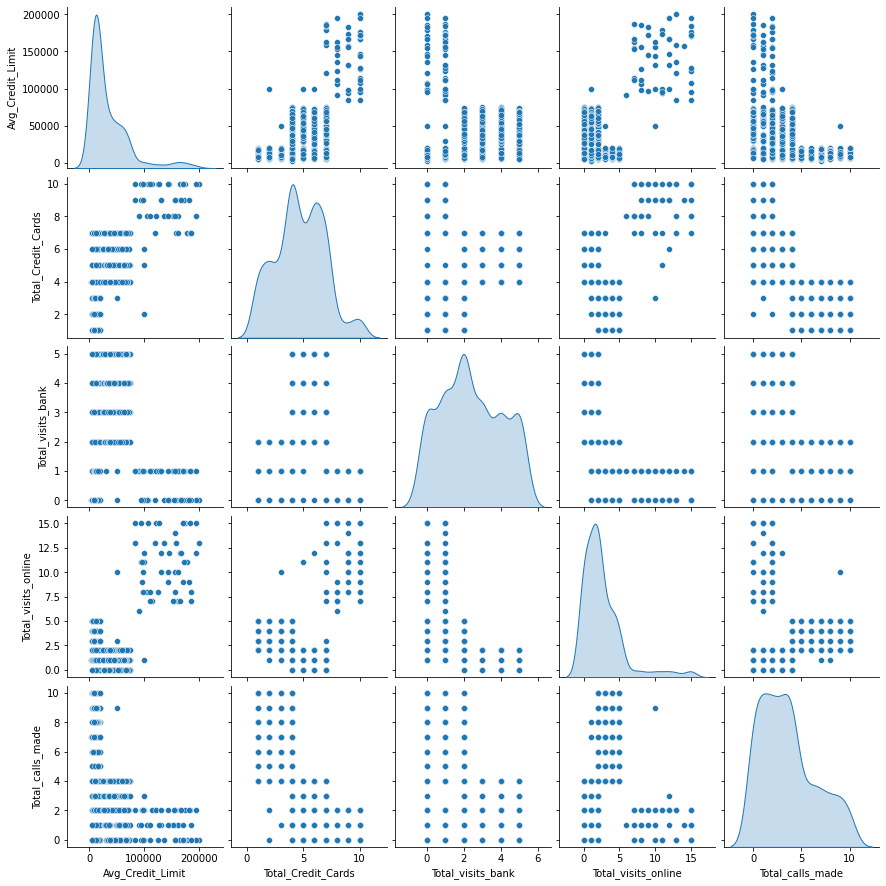

In [8]:
sns.pairplot(data[['Avg_Credit_Limit', 'Total_Credit_Cards', 'Total_visits_bank', 'Total_visits_online', 'Total_calls_made']], diag_kind='kde')

<AxesSubplot:>

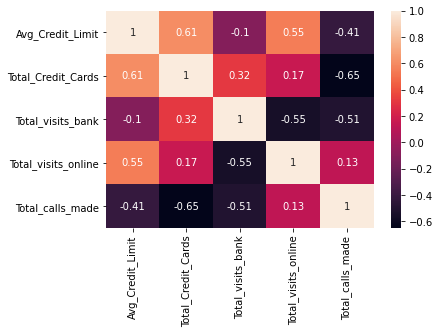

In [9]:
sns.heatmap(data[['Avg_Credit_Limit', 'Total_Credit_Cards', 'Total_visits_bank', 'Total_visits_online', 'Total_calls_made']].corr(), annot=True)

### Duplicate custoner info
Looking at the data I have realised that unique values 'Customer Key' and 'Sl_No' are not the same, so analysing the duplicate data using 'Customer Key'

In [10]:
data_raw = data.copy()
duplicated_data = data[data.duplicated(subset=['Customer Key'])]

### Dropping the 'Customer Key' column and scaling the data

In [11]:
data_scaled = data.copy()
data_scaled[:] = StandardScaler().fit_transform(data_scaled)
data_scaled.drop('Customer Key', axis=1, inplace=True)
data_scaled.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Sl_No,,,,,
1,1.740187,-1.249225,-0.860451,-0.547490,-1.251537
2,0.410293,-0.787585,-1.473731,2.520519,1.891859
3,0.410293,1.058973,-0.860451,0.134290,0.145528
4,-0.121665,0.135694,-0.860451,-0.547490,0.145528
5,1.740187,0.597334,-1.473731,3.202298,-0.203739


## K-Mean 

In [12]:
mean_distortion = []
for k in range(1, 10):
    model=KMeans(n_clusters=k)
    model.fit(data_scaled)
    prediction=model.predict(data_scaled)
    mean_distortion.append(sum(np.min(cdist(data_scaled, model.cluster_centers_, 'euclidean'), axis=1)) / data_scaled.shape[0])

Text(0.5, 1.0, 'Selecting k with the Elbow Method')

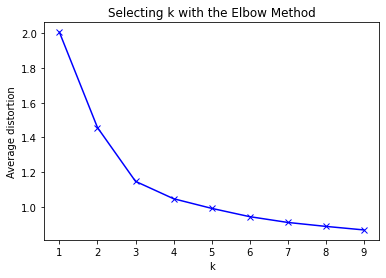

In [13]:
plt.plot(range(1, 10), mean_distortion, 'bx-')
plt.xlabel('k')
plt.ylabel('Average distortion')
plt.title('Selecting k with the Elbow Method')

### Looking at the above elbow diagram, we can see that there is sharp turn at the value 3 on the x-axis. So considering 3 clusters for KMean clustering

In [14]:
model = KMeans(n_clusters=3)
model.fit(data_scaled)
preds = model.predict(data_scaled)

In [15]:
labels = model.labels_
print(silhouette_score(data_scaled, labels, metric='euclidean'))

0.5157182558881063


### Adding the KMeans predection to original data

In [16]:
data['Kmean'] = preds
data_scaled['Kmean'] = preds
data_raw['Kmean'] = preds
data.groupby('Kmean').count()
data_kmean = data.copy()

### Box plot analysis using KMean

array([[<AxesSubplot:title={'center':'Avg_Credit_Limit'}, xlabel='[Kmean]'>,
        <AxesSubplot:title={'center':'Total_Credit_Cards'}, xlabel='[Kmean]'>],
       [<AxesSubplot:title={'center':'Total_calls_made'}, xlabel='[Kmean]'>,
        <AxesSubplot:title={'center':'Total_visits_bank'}, xlabel='[Kmean]'>],
       [<AxesSubplot:title={'center':'Total_visits_online'}, xlabel='[Kmean]'>,
        <AxesSubplot:>]], dtype=object)

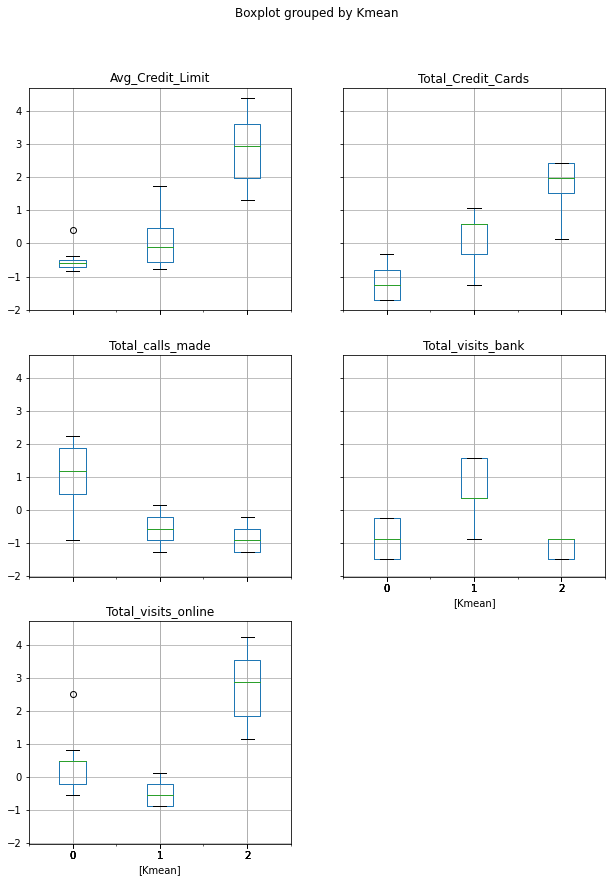

In [17]:
data_scaled.boxplot(by='Kmean', layout=(3,2), figsize=(10,14))

In [18]:
mean_distortion = []
data_scaled.drop('Kmean', inplace=True, axis=1)

##  Hierarchical Clustering

In [19]:
links = ['ward', 'complete', 'average', 'single', 'weighted', 'centroid', 'median']
affs = [ 'euclidean', 'jaccard','mahalanobis', 'minkowski']

In [20]:
cols = list(data_scaled.columns)
for aff in affs:
    for link in links:
        if link == 'ward' and aff != 'euclidean':
            pass
        elif link == 'centroid' and aff != 'euclidean':
            pass
        elif link == 'median' and aff != 'euclidean':
            pass
        else:
            Z = linkage(data_scaled[cols], metric=aff, method=link)
            c, coph_dists = cophenet(Z , pdist(data_scaled[cols]))
            if c > .75:
                print('Affinity: ',aff, ', Link:',link,':', c)

Affinity:  euclidean , Link: complete : 0.8599730607972423
Affinity:  euclidean , Link: average : 0.8977080867389372
Affinity:  euclidean , Link: weighted : 0.8861746814895477
Affinity:  euclidean , Link: centroid : 0.8939385846326323
Affinity:  euclidean , Link: median : 0.8893799537016724
Affinity:  mahalanobis , Link: average : 0.8326994115042136
Affinity:  mahalanobis , Link: weighted : 0.7805990615142517
Affinity:  minkowski , Link: complete : 0.8599730607972423
Affinity:  minkowski , Link: average : 0.8977080867389372
Affinity:  minkowski , Link: weighted : 0.8861746814895477


### From the above results we can explain the data most using the 'euclidean' distance and 'average' linkage 

In [21]:
Z = linkage(data_scaled[cols], metric='euclidean', method='average')
c, coph_dists = cophenet(Z , pdist(data_scaled[cols]))

### Dendrogram

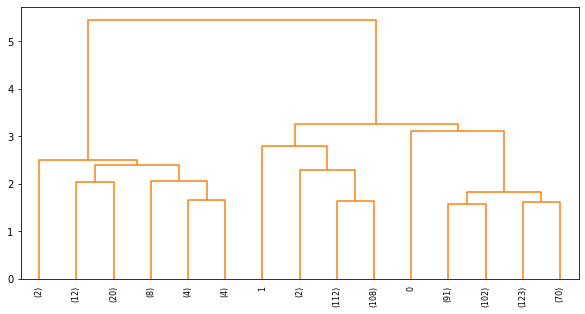

In [22]:
plt.figure(figsize=(10, 5))
dendrogram(Z, p=15, truncate_mode='lastp', leaf_rotation=90.,color_threshold = 40, leaf_font_size=8.)
plt.show()

### Silhouette Score

In [23]:
for k in range(2, 10):
    model=AgglomerativeClustering(n_clusters=k, affinity='euclidean',  linkage='average')
    model.fit(data_scaled)
    prediction=model.labels_
    mean_distortion.append(silhouette_score(data_scaled, prediction))

Text(0.5, 1.0, 'Selecting k with silhouette score')

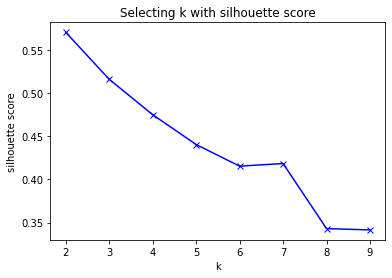

In [24]:
plt.plot(range(2, 10), mean_distortion, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.title('Selecting k with silhouette score')

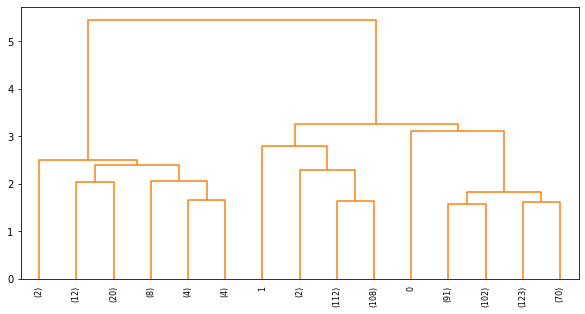

In [25]:
Z = linkage(data_scaled[cols], metric='euclidean', method='average')
c, coph_dists = cophenet(Z , pdist(data_scaled[cols]))
plt.figure(figsize=(10, 5))

dendrogram(Z, p=15, truncate_mode='lastp', leaf_rotation=90.,color_threshold = 40, leaf_font_size=8.)
plt.show()

In [26]:
model=AgglomerativeClustering(n_clusters=2, affinity='euclidean',  linkage='average')
model.fit(data_scaled)
preds=model.labels_
data['hc_grouping'] = preds
data_scaled['hc_grouping'] = preds
data_raw['hc_grouping'] = preds
data.groupby('hc_grouping').count()
data_hc = data.copy()

In [27]:
print(silhouette_score(data_scaled, preds))

0.5778491354896657


### Box plot using 'hc_grouping'

array([[<AxesSubplot:title={'center':'Avg_Credit_Limit'}, xlabel='[hc_grouping]'>,
        <AxesSubplot:title={'center':'Total_Credit_Cards'}, xlabel='[hc_grouping]'>],
       [<AxesSubplot:title={'center':'Total_calls_made'}, xlabel='[hc_grouping]'>,
        <AxesSubplot:title={'center':'Total_visits_bank'}, xlabel='[hc_grouping]'>],
       [<AxesSubplot:title={'center':'Total_visits_online'}, xlabel='[hc_grouping]'>,
        <AxesSubplot:>]], dtype=object)

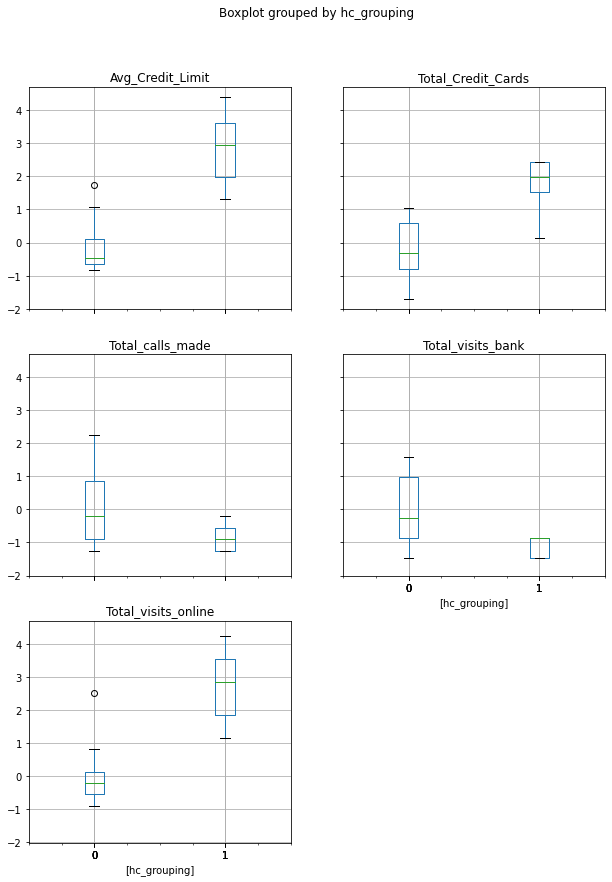

In [28]:
data_scaled.boxplot(by='hc_grouping', layout=(3,2), figsize=(10,14))

### Clustering data 

In [29]:
data_hc.groupby('hc_grouping').count()

,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Kmean
hc_grouping,,,,,,,
0,610,610,610,610,610,610,610
1,50,50,50,50,50,50,50


In [30]:
data_kmean.groupby('Kmean').count()

,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Kmean,,,,,,
0,224,224,224,224,224,224
1,386,386,386,386,386,386
2,50,50,50,50,50,50


## Key Questions & Analysis

### How many different segments of customers are there?
There are 3 distinct types of customers
    1. In-person user
    2. Phone user
    3. Online user

### How are these segments different from each other?
    1. In-person user: These users have few credit cards
    2. Phone user: These users prefer to call
    3. Online user: These are tech savvy users and prefer to perform transactions online.

### What are your recommendations to the bank on how to better market to and service these customers?


In [31]:
for k in duplicated_data['Customer Key']:
    display(data_raw.loc[data_raw['Customer Key'] == k])

,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Kmean,hc_grouping
Sl_No,,,,,,,,
5,47437,100000,6,0,12,3,2,1
333,47437,17000,7,3,1,0,1,0


,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Kmean,hc_grouping
Sl_No,,,,,,,,
392,96929,13000,4,5,0,0,1,0
399,96929,67000,6,2,2,2,1,0


,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Kmean,hc_grouping
Sl_No,,,,,,,,
49,37252,6000,4,0,2,8,0,0
433,37252,59000,6,2,1,2,1,0


,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Kmean,hc_grouping
Sl_No,,,,,,,,
412,50706,44000,4,5,0,2,1,0
542,50706,60000,7,5,2,2,1,0


,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Kmean,hc_grouping
Sl_No,,,,,,,,
105,97935,17000,2,1,2,10,0,0
633,97935,187000,7,1,7,0,2,1


### Recommendation

Looking at the 5 duplicate customer records we can recommend the bank to incentivize customers to switch to digital platforms there by increasing the sale of credit cards.